In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('../Data/heart_disease_uci.csv')

# Preview
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


In [3]:
X_reg = df.drop(columns=['chol'])
y_reg = df['chol']


In [4]:
# Ensure binary classification: 0 = no disease, 1 = disease
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

X_cls = df.drop(columns=['num'])
y_cls = df['num']


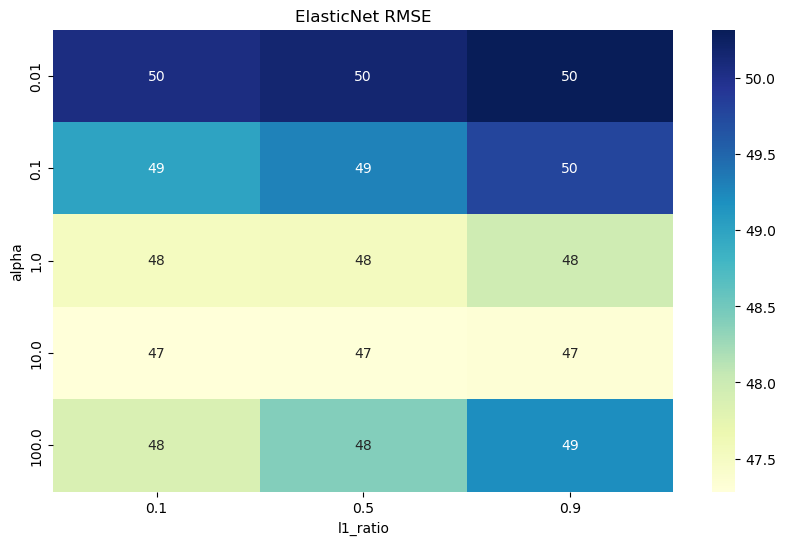

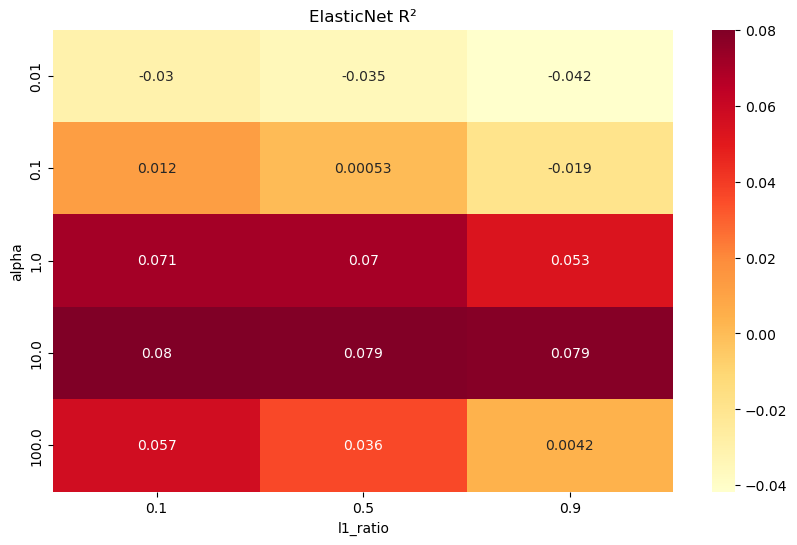

Best ElasticNet config:
   alpha  l1_ratio       RMSE       R2
9   10.0       0.1  47.283114  0.08014


/Users/rhythm/Desktop/ML/.pixi/envs/default/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


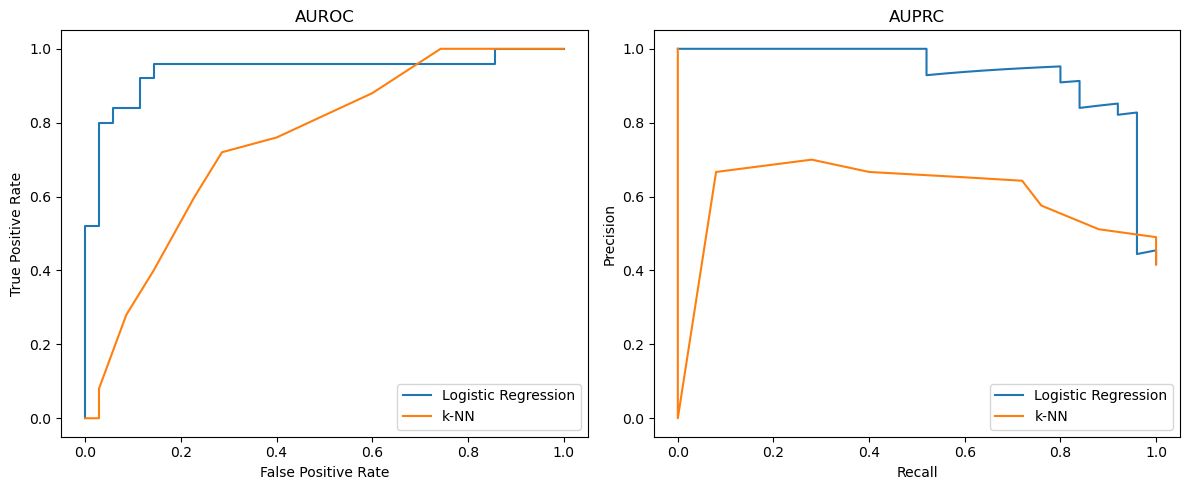

Logistic Regression Results:
      penalty     solver  accuracy  f1_score     AUROC     AUPRC
0          l2      lbfgs  0.866667  0.840000  0.940571  0.938858
1          l1  liblinear  0.883333  0.862745  0.938286  0.932604
2  elasticnet       saga  0.883333  0.851064  0.928000  0.918817

k-NN Results:
    k  accuracy  f1_score     AUROC     AUPRC
0   1  0.583333  0.489796  0.568571  0.598333
1   5  0.650000  0.533333  0.678286  0.581173
2  10  0.700000  0.625000  0.750286  0.604644


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_curve, auc, roc_curve
)

df = pd.read_csv('../Data/heart_disease_uci.csv')
df.dropna(inplace=True)
df = pd.get_dummies(df)
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Part 3: Regression
X_reg = df.drop(columns=['chol', 'num'])
y_reg = df['chol']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

alphas = [0.01, 0.1, 1, 10, 100]
l1_ratios = [0.1, 0.5, 0.9]
reg_results = []

for alpha in alphas:
    for l1 in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42, max_iter=10000)
        model.fit(X_train_reg, y_train_reg)
        y_pred = model.predict(X_test_reg)
        rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
        r2 = r2_score(y_test_reg, y_pred)
        reg_results.append({'alpha': alpha, 'l1_ratio': l1, 'RMSE': rmse, 'R2': r2})

reg_df = pd.DataFrame(reg_results)

plt.figure(figsize=(10, 6))
sns.heatmap(reg_df.pivot(index="alpha", columns="l1_ratio", values="RMSE"), annot=True, cmap="YlGnBu")
plt.title("ElasticNet RMSE")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(reg_df.pivot(index="alpha", columns="l1_ratio", values="R2"), annot=True, cmap="YlOrRd")
plt.title("ElasticNet R²")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")
plt.show()

best_reg_config = reg_df.sort_values(by="R2", ascending=False).head(1)
print("Best ElasticNet config:")
print(best_reg_config)

# Part 4: Classification
X_cls = df.drop(columns=['chol', 'num'])
y_cls = df['num']
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

log_configs = [
    {"penalty": "l2", "solver": "lbfgs"},
    {"penalty": "l1", "solver": "liblinear"},
    {"penalty": "elasticnet", "solver": "saga"}
]

log_results = []

for config in log_configs:
    try:
        if config["penalty"] == "elasticnet":
            model = LogisticRegression(penalty=config["penalty"], solver=config["solver"], l1_ratio=0.5, max_iter=1000)
        else:
            model = LogisticRegression(penalty=config["penalty"], solver=config["solver"], max_iter=1000)
        model.fit(X_train_cls, y_train_cls)
        y_prob = model.predict_proba(X_test_cls)[:, 1]
        y_pred = model.predict(X_test_cls)
        acc = accuracy_score(y_test_cls, y_pred)
        f1 = f1_score(y_test_cls, y_pred)
        roc_auc = roc_auc_score(y_test_cls, y_prob)
        pr_precision, pr_recall, _ = precision_recall_curve(y_test_cls, y_prob)
        pr_auc = auc(pr_recall, pr_precision)
        log_results.append({
            "penalty": config["penalty"],
            "solver": config["solver"],
            "accuracy": acc,
            "f1_score": f1,
            "AUROC": roc_auc,
            "AUPRC": pr_auc,
            "model": model,
            "y_prob": y_prob
        })
    except:
        continue

log_df = pd.DataFrame([{k: v for k, v in d.items() if k not in ['model', 'y_prob']} for d in log_results])
best_log_model = max(log_results, key=lambda x: x['AUROC'])

k_values = [1, 5, 10]
knn_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_cls, y_train_cls)
    y_prob = knn.predict_proba(X_test_cls)[:, 1]
    y_pred = knn.predict(X_test_cls)
    acc = accuracy_score(y_test_cls, y_pred)
    f1 = f1_score(y_test_cls, y_pred)
    roc_auc = roc_auc_score(y_test_cls, y_prob)
    pr_precision, pr_recall, _ = precision_recall_curve(y_test_cls, y_prob)
    pr_auc = auc(pr_recall, pr_precision)
    knn_results.append({
        "k": k,
        "accuracy": acc,
        "f1_score": f1,
        "AUROC": roc_auc,
        "AUPRC": pr_auc,
        "model": knn,
        "y_prob": y_prob
    })

knn_df = pd.DataFrame([{k: v for k, v in d.items() if k not in ['model', 'y_prob']} for d in knn_results])
best_knn_model = max(knn_results, key=lambda x: x['AUROC'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_cls, best_log_model['y_prob'])
plt.plot(fpr, tpr, label='Logistic Regression')
fpr, tpr, _ = roc_curve(y_test_cls, best_knn_model['y_prob'])
plt.plot(fpr, tpr, label='k-NN')
plt.title("AUROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test_cls, best_log_model['y_prob'])
plt.plot(rec, prec, label='Logistic Regression')
prec, rec, _ = precision_recall_curve(y_test_cls, best_knn_model['y_prob'])
plt.plot(rec, prec, label='k-NN')
plt.title("AUPRC")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

print("Logistic Regression Results:")
print(log_df)

print("\nk-NN Results:")
print(knn_df)